# Segmenting and Clustering Neighborhoods in Toronto, Ontario

## Introduction
We use the csv file from our TO_LatLongs.ipynb Notebook to cluster Toronto Neighbourhoods. We will utilize the Foursquare API to explore these neighbourhoods using the 'explore" function of the API. 

We will use the "k-means" clustering algorithm to complete the task and use the Folium Library to visualize the results.


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    sci

<a id='item1'></a>

## 1. Download and Explore Dataset

#### Load and explore the data

We load and transform our saved ''TO_LatLongs.csv' file into pandas DataFrame

In [2]:
DF_hoods = pd.read_csv('TO_LatLongs.csv') #We read saved csv to a DataFrame
DF_hoods.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Use geopy library to get the latitude and longitude values of Toronto, Ontario.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [3]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [4]:
# create map of Toronto using latitude and longitude values
map_TO = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(DF_hoods['Latitude'], DF_hoods['Longitude'], DF_hoods['Borough'], DF_hoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_TO)  
    
map_TO

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [5]:
CLIENT_ID = 'MCGUZVNNPYV1TU5HO0YXZRNIEXYGYYOXKZW4Z3140UGRFPQR' # your Foursquare ID
CLIENT_SECRET = 'GCJM03TEROEQEKIUE0A0OHGEG14XSPAW0055KWLEXVMQUSEK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MCGUZVNNPYV1TU5HO0YXZRNIEXYGYYOXKZW4Z3140UGRFPQR
CLIENT_SECRET:GCJM03TEROEQEKIUE0A0OHGEG14XSPAW0055KWLEXVMQUSEK


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [6]:
DF_hoods.loc[0, 'Neighbourhood']

'Rouge, Malvern'

Get the neighborhood's latitude and longitude values.

In [7]:
neighborhood_latitude = DF_hoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = DF_hoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = DF_hoods.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge, Malvern are 43.8066863, -79.19435340000003.


#### Now, let's get the top 100 venues that are in Rouge and Malvern within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [8]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url



'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id=MCGUZVNNPYV1TU5HO0YXZRNIEXYGYYOXKZW4Z3140UGRFPQR&client_secret=GCJM03TEROEQEKIUE0A0OHGEG14XSPAW0055KWLEXVMQUSEK&v=20180605&ll=43.8066863,-79.19435340000003&radius=500&limit=100'

Send the GET request and examine the resutls

In [9]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e3abe9040a7ea001b05a403'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'query': 'food',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.811186304500005,
    'lng': -79.18812958073043},
   'sw': {'lat': 43.8021862955, 'lng': -79.20057721926962}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': "Wendy's",
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLn

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['shortName'] #This returns the short form of the name to the restuarant category

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [11]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Wendy's,Fast Food,43.807448,-79.199056
1,Meena's Fine Foods,Indian,43.804476,-79.199753


And how many venues were returned by Foursquare?

In [12]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['shortName']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *Toronto_venues*.

In [14]:

Toronto_venues = getNearbyVenues(names=DF_hoods['Neighbourhood'],
                                   latitudes=DF_hoods['Latitude'],
                                   longitudes=DF_hoods['Longitude']
                                  )



Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

#### Let's check the size of the resulting dataframe

In [15]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1681, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food
1,"Rouge, Malvern",43.806686,-79.194353,Meena's Fine Foods,43.804476,-79.199753,Indian
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Doug's Bakery,43.762400,-79.192285,Bakery
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant


Let's check how many venues were returned for each neighborhood

In [16]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",92,92,92,92,92,92
Agincourt,3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",5,5,5,5,5,5
"Alderwood, Long Branch",4,4,4,4,4,4
"Bathurst Manor, Downsview North, Wilson Heights",9,9,9,9,9,9
Bayview Village,3,3,3,3,3,3
"Bedford Park, Lawrence Manor East",21,21,21,21,21,21
Berczy Park,53,53,53,53,53,53
"Birch Cliff, Cliffside West",3,3,3,3,3,3


#### Let's find out how many unique categories can be curated from all the returned venues

In [17]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 92 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [18]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighborhood,Afghan,American,Arepas,Argentinian,Asian,BBQ,Bagels,Bakery,Belgian,Bistro,Brazilian,Breakfast,Burgers,Burritos,Cafeteria,Café,Cajun / Creole,Caribbean,Chinese,Colombian,Comfort Food,Creperie,Cuban,Deli / Bodega,Dim Sum,Diner,Doner,Donuts,Dumplings,Eastern European,Empanada,Ethiopian,Falafel,Fast Food,Filipino,Fish & Chips,Food,Food Court,Food Truck,French,Fried Chicken,Gastropub,German,Gluten-free,Greek,Hakka,Hot Dogs,Indian,Indonesian,Irish,Italian,Japanese,Korean,Latin American,Mac & Cheese,Malay,Mediterranean,Mexican,Middle Eastern,Modern European,Molecular Gastronomy,Moroccan,New American,Noodles,North Indian,Peking Duck,Persian,Pizza,Poke Place,Polish,Portuguese,Poutine Place,Ramen,Restaurant,Salad,Sandwiches,Seafood,Shawarma Place,Snacks,Soup,South American,Southern / Soul,Steakhouse,Sushi,Tacos,Taiwanese,Tapas,Thai,Theme Restaurant,Vegetarian / Vegan,Vietnamese,Wings
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [19]:
Toronto_onehot.shape

(1681, 93)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [20]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Afghan,American,Arepas,Argentinian,Asian,BBQ,Bagels,Bakery,Belgian,Bistro,Brazilian,Breakfast,Burgers,Burritos,Cafeteria,Café,Cajun / Creole,Caribbean,Chinese,Colombian,Comfort Food,Creperie,Cuban,Deli / Bodega,Dim Sum,Diner,Doner,Donuts,Dumplings,Eastern European,Empanada,Ethiopian,Falafel,Fast Food,Filipino,Fish & Chips,Food,Food Court,Food Truck,French,Fried Chicken,Gastropub,German,Gluten-free,Greek,Hakka,Hot Dogs,Indian,Indonesian,Irish,Italian,Japanese,Korean,Latin American,Mac & Cheese,Malay,Mediterranean,Mexican,Middle Eastern,Modern European,Molecular Gastronomy,Moroccan,New American,Noodles,North Indian,Peking Duck,Persian,Pizza,Poke Place,Polish,Portuguese,Poutine Place,Ramen,Restaurant,Salad,Sandwiches,Seafood,Shawarma Place,Snacks,Soup,South American,Southern / Soul,Steakhouse,Sushi,Tacos,Taiwanese,Tapas,Thai,Theme Restaurant,Vegetarian / Vegan,Vietnamese,Wings
0,"Adelaide, King, Richmond",0.000000,0.043478,0.000000,0.000000,0.054348,0.000000,0.010870,0.032609,0.000000,0.000000,0.010870,0.032609,0.032609,0.021739,0.000000,0.086957,0.000000,0.000000,0.010870,0.01087,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.021739,0.0000,0.01087,0.021739,0.0,0.000000,0.010870,0.000000,0.000000,0.032609,0.010870,0.000000,0.010870,0.000000,0.000000,0.010870,0.010870,0.010870,0.010870,0.0000,0.000000,0.010870,0.010870,0.000000,0.000000,0.000000,0.021739,0.010870,0.000000,0.000000,0.010870,0.010870,0.065217,0.032609,0.054348,0.021739,0.000000,0.000000,0.01087,0.000000,0.000000,0.043478,0.032609,0.00,0.000000,0.000000,0.054348,0.000000,0.032609,0.000000,0.000000
1,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.0000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Alderwood, Long Branch",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0

#### Let's confirm the new size

In [21]:
Toronto_grouped.shape

(91, 93)

#### Let's print each neighborhood along with the top 5 most common venues

In [22]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
        venue  freq
0        Café  0.09
1  Restaurant  0.07
2  Sandwiches  0.05
3        Thai  0.05
4       Asian  0.05


----Agincourt----
             venue  freq
0   Latin American  0.33
1          Chinese  0.33
2        Breakfast  0.33
3           Afghan  0.00
4  Modern European  0.00


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
             venue  freq
0            Pizza   0.4
1         Japanese   0.2
2    Fried Chicken   0.2
3       Sandwiches   0.2
4  Modern European   0.0


----Alderwood, Long Branch----
        venue  freq
0       Pizza  0.50
1     Burgers  0.25
2  Sandwiches  0.25
3      Polish  0.00
4     Persian  0.00


----Bathurst Manor, Downsview North, Wilson Heights----
           venue  freq
0          Pizza  0.11
1          Diner  0.11
2  Deli / Bodega  0.11
3     Restaurant  0.11
4  Fried Chicken  0.11


----Bayview Village----
                  venue  freq
0 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [24]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Café,Restaurant,Asian,Sandwiches,Thai
1,Agincourt,Breakfast,Chinese,Latin American,Fast Food,Diner
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza,Fried Chicken,Japanese,Sandwiches,Wings
3,"Alderwood, Long Branch",Pizza,Burgers,Sandwiches,Deli / Bodega,Dim Sum
4,"Bathurst Manor, Downsview North, Wilson Heights",Pizza,Fried Chicken,Deli / Bodega,Chinese,Diner


In [25]:
DF_demografiks = pd.read_csv('TO_latlongDemographic.csv')
DF_demografiks.head()

,Postcode,Borough,Neighbourhood,Latitude_x,Longitude_x,Latitude_y,Longitude_y,Riding,Canadian,Chinese,East Indian,English,Filipino,French,German,Greek,Iranian,Irish,Italian,Jamaican,Korean,Polish,Portuguese,Russian,Scottish,Sri Lankan,Ukrainian,Vietnamese
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,43.806686,-79.194353,Scarborough-Rouge Park,11.8,0.0,16.7,9.8,9.3,0.0,0.0,0.0,0.0,7.0,0.0,8.4,0.0,0.0,0.0,0.0,7.2,11.1,0.0,0.0
1,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,43.836125,-79.205636,Scarborough-Rouge Park,11.8,0.0,16.7,9.8,9.3,0.0,0.0,0.0,0.0,7.0,0.0,8.4,0.0,0.0,0.0,0.0,7.2,11.1,0.0,0.0
2,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,43.784535,-79.160497,Scarborough-Rouge Park,11.8,0.0,16.7,9.8,9.3,0.0,0.0,0.0,0.0,7.0,0.0,8.4,0.0,0.0,0.0,0.0,7.2,11.1,0.0,0.0
3,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,43.763573,-79.188711,Scarborough-Guildwood,11.6,7.1,18.0,9.7,8.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.8,0.0,0.0
4,M1G,Scarborough,Woburn,43.770992,-79.216917,43.770992,-79.216917,Scarborough-Guildwood,11.6,7.1,18.0,9.7,8.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.8,0.0,0.0


In [26]:
DF_Demo = DF_demografiks[['Neighbourhood','Canadian', 'Chinese',
       'East Indian', 'English', 'Filipino', 'French', 'German', 'Greek',
       'Iranian', 'Irish', 'Italian', 'Jamaican', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Sri Lankan', 'Ukrainian',
       'Vietnamese']]
value_s = ['Canadian', 'Chinese','East Indian', 'English', 'Filipino', 'French', 'German', 'Greek','Iranian', 'Irish', 'Italian', 'Jamaican', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Sri Lankan', 'Ukrainian',
       'Vietnamese']
DF_Demo[value_s] = DF_Demo[value_s].div(100)
DF_Demo.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Neighbourhood,Canadian,Chinese,East Indian,English,Filipino,French,German,Greek,Iranian,Irish,Italian,Jamaican,Korean,Polish,Portuguese,Russian,Scottish,Sri Lankan,Ukrainian,Vietnamese
0,"Rouge, Malvern",0.118,0.000,0.167,0.098,0.093,0.0,0.0,0.0,0.0,0.07,0.0,0.084,0.0,0.0,0.0,0.0,0.072,0.111,0.0,0.0
1,"Rouge, Malvern",0.118,0.000,0.167,0.098,0.093,0.0,0.0,0.0,0.0,0.07,0.0,0.084,0.0,0.0,0.0,0.0,0.072,0.111,0.0,0.0
2,"Highland Creek, Rouge Hill, Port Union",0.118,0.000,0.167,0.098,0.093,0.0,0.0,0.0,0.0,0.07,0.0,0.084,0.0,0.0,0.0,0.0,0.072,0.111,0.0,0.0
3,"Guildwood, Morningside, West Hill",0.116,0.071,0.180,0.097,0.085,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.070,0.078,0.0,0.0
4,Woburn,0.116,0.071,0.180,0.097,0.085,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.070,0.078,0.0,0.0


In [27]:
DF_Demo.drop_duplicates('Neighbourhood',keep='first', inplace=True)
DF_Demo.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
DF_Demo.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Neighborhood,Canadian,Chinese,East Indian,English,Filipino,French,German,Greek,Iranian,Irish,Italian,Jamaican,Korean,Polish,Portuguese,Russian,Scottish,Sri Lankan,Ukrainian,Vietnamese
0,"Rouge, Malvern",0.118,0.000,0.167,0.098,0.093,0.0,0.0,0.0,0.0,0.07,0.0,0.084,0.0,0.0,0.0,0.0,0.072,0.111,0.0,0.0
2,"Highland Creek, Rouge Hill, Port Union",0.118,0.000,0.167,0.098,0.093,0.0,0.0,0.0,0.0,0.07,0.0,0.084,0.0,0.0,0.0,0.0,0.072,0.111,0.0,0.0
3,"Guildwood, Morningside, West Hill",0.116,0.071,0.180,0.097,0.085,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.070,0.078,0.0,0.0
4,Woburn,0.116,0.071,0.180,0.097,0.085,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.070,0.078,0.0,0.0
5,Cedarbrae,0.116,0.071,0.180,0.097,0.085,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.070,0.078,0.0,0.0


<a id='item4'></a>

In [28]:
Toronto_demo = pd.merge(left=Toronto_grouped,right=DF_Demo, on='Neighborhood', how='left')
Toronto_demo.head()

,Neighborhood,Afghan,American,Arepas,Argentinian,Asian,BBQ,Bagels,Bakery,Belgian,Bistro,Brazilian,Breakfast,Burgers,Burritos,Cafeteria,Café,Cajun / Creole,Caribbean,Chinese_x,Colombian,Comfort Food,Creperie,Cuban,Deli / Bodega,Dim Sum,Diner,Doner,Donuts,Dumplings,Eastern European,Empanada,Ethiopian,Falafel,Fast Food,Filipino_x,Fish & Chips,Food,Food Court,Food Truck,French_x,Fried Chicken,Gastropub,German_x,Gluten-free,Greek_x,Hakka,Hot Dogs,Indian,Indonesian,Irish_x,Italian_x,Japanese,Korean_x,Latin American,Mac & Cheese,Malay,Mediterranean,Mexican,Middle Eastern,Modern European,Molecular Gastronomy,Moroccan,New American,Noodles,North Indian,Peking Duck,Persian,Pizza,Poke Place,Polish_x,Portuguese_x,Poutine Place,Ramen,Restaurant,Salad,Sandwiches,Seafood,Shawarma Place,Snacks,Soup,South American,Southern / Soul,Steakhouse,Sushi,Tacos,Taiwanese,Tapas,Thai,Theme Restaurant,Vegetarian / Vegan,Vietnamese_x,Wings,Canadian,Chinese_y,East Indian,English,Filipino_y,French_y,German_y,Greek_y,Iranian,Irish_y,Italian_y,Jamaican,Korean_y,Polish_y,Portuguese_y,Russian,Scottish,Sri Lankan,Ukrainian,Vietnamese_y
0,"Adelaide, King, Richmond",0.0,0.043478,0.0,0.0,0.054348,0.0,0.01087,0.032609,0.0,0.0,0.01087,0.032609,0.032609,0.021739,0.0,0.086957,0.0,0.0,0.010870,0.01087,0.0,0.0,0.0,0.043478,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021739,0.0,0.0,0.000000,0.021739,0.0,0.01087,0.021739,0.0,0.0,0.01087,0.0,0.0,0.032609,0.01087,0.0,0.010870,0.0,0.0,0.01087,0.01087,0.010870,0.01087,0.0,0.0,0.01087,0.01087,0.0,0.0,0.0,0.021739,0.01087,0.0,0.0,0.01087,0.01087,0.065217,0.032609,0.054348,0.021739,0.0,0.0,0.01087,0.0,0.0,0.043478,0.032609,0.0,0.0,0.0,0.054348,0.0,0.032609,0.0,0.0,0.140,0.160,0.000,0.164,0.00,0.077,0.076,0.0,0.0,0.146,0.000,0.0,0.0,0.000,0.0,0.000,0.132,0.000,0.000,0.0
1,Agincourt,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.333333,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.333333,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000,0.466,0.118,0.000,0.00,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.094,0.000,0.0
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.200000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.20000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.400000,0.00000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.200000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.079,0.000,0.222,0.000,0.00,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.0
3,"Alderwood, Long Branch",0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.250000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.500000,0.00000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.250000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.159,0.000,0.000,0.171,0.00,0.000,0.071,0.0,0.0,0.144,0.091,0.0,0.0,0.092,0.0,0.000,0.135,0.000,0.076,0.0
4,"Bathurst Manor, Downsview North, Wilson Heights",0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000

In [29]:
Toronto_demo.shape

(91, 113)

In [30]:
import scipy.sparse #We check for sparseness
scipy.sparse.issparse(Toronto_demo)

False

Apparently the data is not sparse, so we will use the normal dense functions

#### In order to make working with the data more convenient, we set the index, so that we can have only the features as column names

In [31]:
Toronto_demo1 = Toronto_demo.set_index('Neighborhood') #set index as Neighborhood
Toronto_demo1.index.names = ['Neighborhood'] #set index names
Toronto_demo1.columns.names = ['Features']#Set column name as features
Toronto_demo1.head()

Features,Afghan,American,Arepas,Argentinian,Asian,BBQ,Bagels,Bakery,Belgian,Bistro,Brazilian,Breakfast,Burgers,Burritos,Cafeteria,Café,Cajun / Creole,Caribbean,Chinese_x,Colombian,Comfort Food,Creperie,Cuban,Deli / Bodega,Dim Sum,Diner,Doner,Donuts,Dumplings,Eastern European,Empanada,Ethiopian,Falafel,Fast Food,Filipino_x,Fish & Chips,Food,Food Court,Food Truck,French_x,Fried Chicken,Gastropub,German_x,Gluten-free,Greek_x,Hakka,Hot Dogs,Indian,Indonesian,Irish_x,Italian_x,Japanese,Korean_x,Latin American,Mac & Cheese,Malay,Mediterranean,Mexican,Middle Eastern,Modern European,Molecular Gastronomy,Moroccan,New American,Noodles,North Indian,Peking Duck,Persian,Pizza,Poke Place,Polish_x,Portuguese_x,Poutine Place,Ramen,Restaurant,Salad,Sandwiches,Seafood,Shawarma Place,Snacks,Soup,South American,Southern / Soul,Steakhouse,Sushi,Tacos,Taiwanese,Tapas,Thai,Theme Restaurant,Vegetarian / Vegan,Vietnamese_x,Wings,Canadian,Chinese_y,East Indian,English,Filipino_y,French_y,German_y,Greek_y,Iranian,Irish_y,Italian_y,Jamaican,Korean_y,Polish_y,Portuguese_y,Russian,Scottish,Sri Lankan,Ukrainian,Vietnamese_y
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",0.0,0.043478,0.0,0.0,0.054348,0.0,0.01087,0.032609,0.0,0.0,0.01087,0.032609,0.032609,0.021739,0.0,0.086957,0.0,0.0,0.010870,0.01087,0.0,0.0,0.0,0.043478,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021739,0.0,0.0,0.000000,0.021739,0.0,0.01087,0.021739,0.0,0.0,0.01087,0.0,0.0,0.032609,0.01087,0.0,0.010870,0.0,0.0,0.01087,0.01087,0.010870,0.01087,0.0,0.0,0.01087,0.01087,0.0,0.0,0.0,0.021739,0.01087,0.0,0.0,0.01087,0.01087,0.065217,0.032609,0.054348,0.021739,0.0,0.0,0.01087,0.0,0.0,0.043478,0.032609,0.0,0.0,0.0,0.054348,0.0,0.032609,0.0,0.0,0.140,0.160,0.000,0.164,0.00,0.077,0.076,0.0,0.0,0.146,0.000,0.0,0.0,0.000,0.0,0.000,0.132,0.000,0.000,0.0
Agincourt,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.333333,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.333333,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000,0.466,0.118,0.000,0.00,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.094,0.000,0.0
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.200000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.20000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.400000,0.00000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.200000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.079,0.000,0.222,0.000,0.00,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.0
"Alderwood, Long Branch",0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.250000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.500000,0.00000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.250000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.159,0.000,0.000,0.171,0.00,0.000,0.

In [39]:
Toronto_demo1.shape

(91, 112)

We have 112 features to work with from the shape of the data.

#### We check the correlation between the features using a heat map

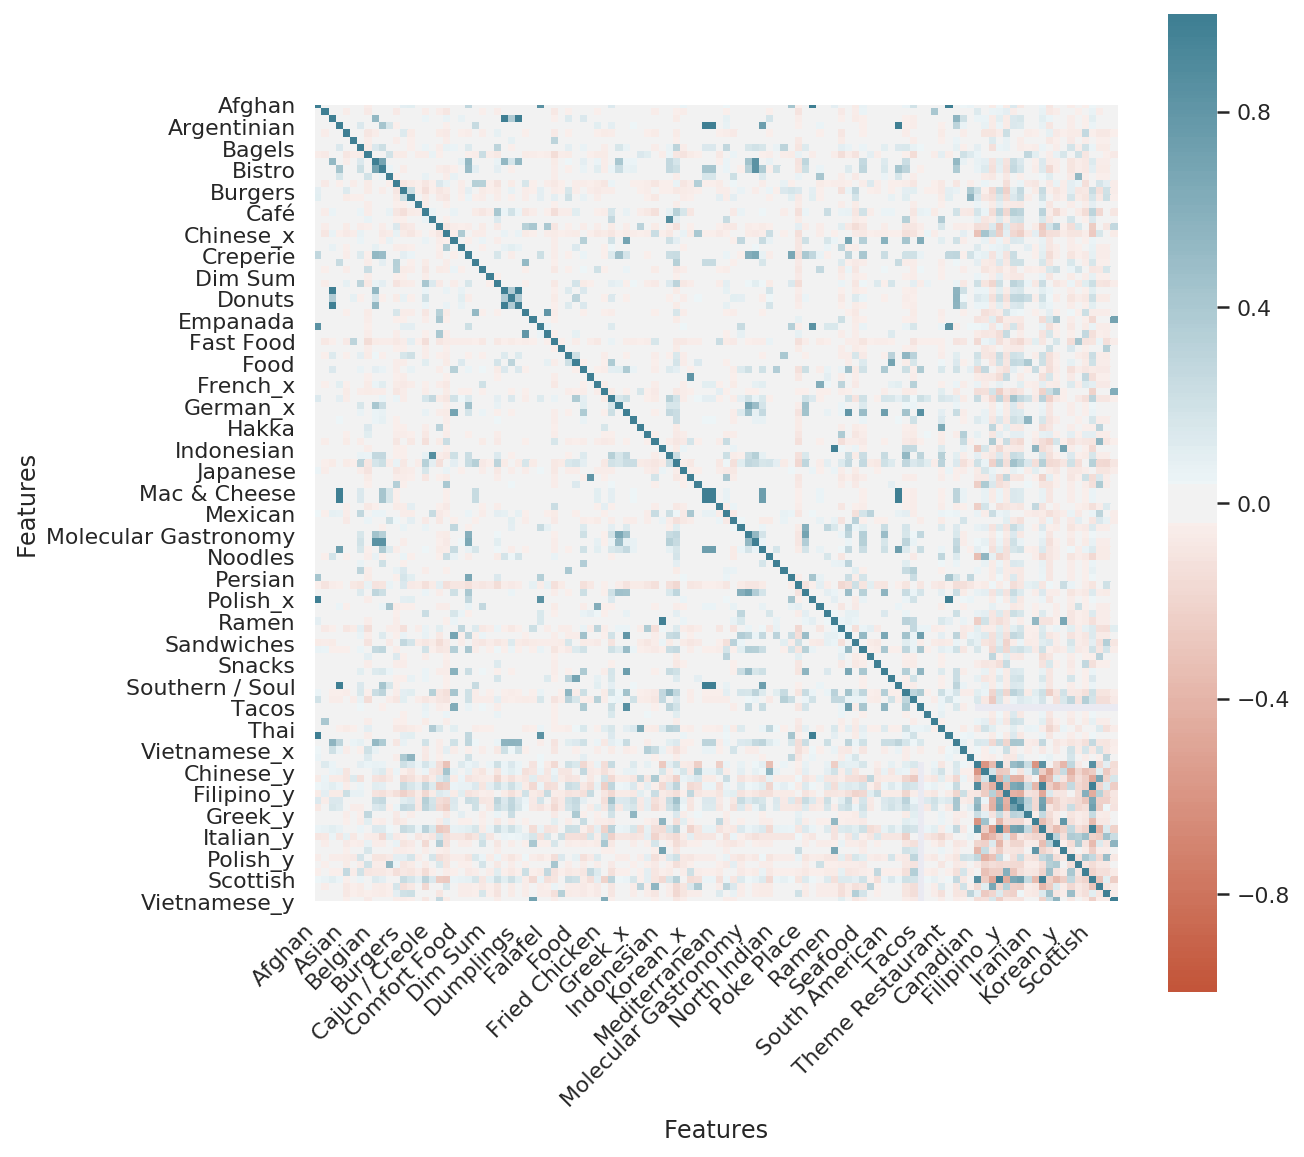

In [43]:
import seaborn as sns

corr = Toronto_demo1.corr()
sns.set(rc={'figure.figsize':(9,9)})
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### We find the most common ethnicities for each neighborhood

In [44]:
# Set up a function to return the most common ethnicities for each neighborhood
def return_most_common_ethnicity(row, num_top_ethnicity):
    row_categories_ = row.iloc[1:]
    row_categories_sorted_ = row_categories_.sort_values(ascending=False)
    
    return row_categories_sorted_.index.values[0:num_top_ethnicity]

In [45]:
# Apply the return_most_common_ethnicity function on each neighborhood
num_top_ethnicity = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
column_s = ['Neighborhood']
for ind in np.arange(num_top_ethnicity):
    try:
        column_s.append('{}{} Most Common ethnicity'.format(ind+1, indicators[ind]))
    except:
        column_s.append('{}th Most Common ethnicity'.format(ind+1))

# create a new dataframe
neighborhoods_ethnicity_sorted = pd.DataFrame(columns=column_s)
neighborhoods_ethnicity_sorted['Neighborhood'] = DF_Demo['Neighborhood']

for ind in np.arange(DF_Demo.shape[0]):
    neighborhoods_ethnicity_sorted.iloc[ind, 1:] = return_most_common_ethnicity(DF_Demo.iloc[ind, :], num_top_ethnicity)

neighborhoods_ethnicity_sorted.head()

,Neighborhood,1st Most Common ethnicity,2nd Most Common ethnicity,3rd Most Common ethnicity,4th Most Common ethnicity,5th Most Common ethnicity
0,"Rouge, Malvern",East Indian,Canadian,Sri Lankan,English,Filipino
2,"Highland Creek, Rouge Hill, Port Union",East Indian,Canadian,Sri Lankan,English,Filipino
3,"Guildwood, Morningside, West Hill",East Indian,Canadian,English,Filipino,Sri Lankan
4,Woburn,East Indian,Canadian,English,Filipino,Sri Lankan
5,Cedarbrae,East Indian,Canadian,English,Filipino,Sri Lankan


#### We merge the Dataframe showing the most common ethnicity with the one showing the most common venue.

In [34]:
Toronto_merged_sorted = pd.merge(left=neighborhoods_venues_sorted,right=neighborhoods_ethnicity_sorted, on='Neighborhood', how='left')
Toronto_merged_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common ethnicity,2nd Most Common ethnicity,3rd Most Common ethnicity,4th Most Common ethnicity,5th Most Common ethnicity
0,"Adelaide, King, Richmond",Café,Restaurant,Asian,Sandwiches,Thai,English,Chinese,Irish,Canadian,Scottish
1,Agincourt,Breakfast,Chinese,Latin American,Fast Food,Diner,Chinese,East Indian,Sri Lankan,Vietnamese,Iranian
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza,Fried Chicken,Japanese,Sandwiches,Wings,East Indian,Canadian,Ukrainian,Chinese,English
3,"Alderwood, Long Branch",Pizza,Burgers,Sandwiches,Deli / Bodega,Dim Sum,English,Canadian,Irish,Scottish,Polish
4,"Bathurst Manor, Downsview North, Wilson Heights",Pizza,Fried Chicken,Deli / Bodega,Chinese,Diner,Filipino,Italian,Russian,Canadian,Iranian



#### Looking at our Dataframe, we can see that the number of features (at 112) is quite large. We will use Principal Component Analysis (PCA) to limit the number of features. This according to [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis) uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

In [35]:
import numpy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'

TO_std = StandardScaler().fit_transform(Toronto_demo1)
#numpy.isnan(TO_std).any()
TO_std[numpy.isnan(TO_std)] = 0

# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(TO_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

#### At this stage, we are not sure of the optimum number of components. We make a plot of the percentage of explained variance against the number of features (components).

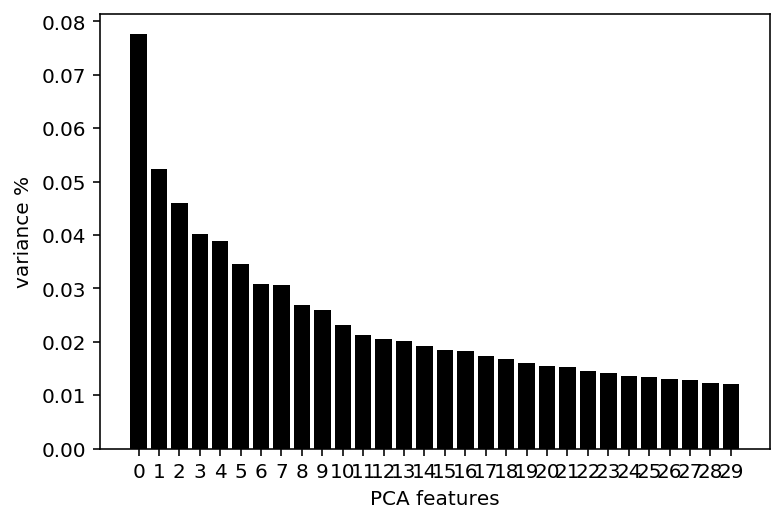

In [36]:
pca_1 = PCA(n_components=30)
principalComponents_1 = pca_1.fit_transform(TO_std)
# Plot the explained variances
features_1 = range(pca_1.n_components_)
plt.bar(features_1, pca_1.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features_1)
# Save components to a DataFrame
PCA_components1 = pd.DataFrame(principalComponents_1)

#### We can see that we are able to capture most of the variance in the data after 10 components. So we will use a PCA with 10 components


#### Using the PCA with 10 components, we try to find the optimal number of clusters for our *k-means clustering* We do this by plotting  the number of clusters against the inertia.

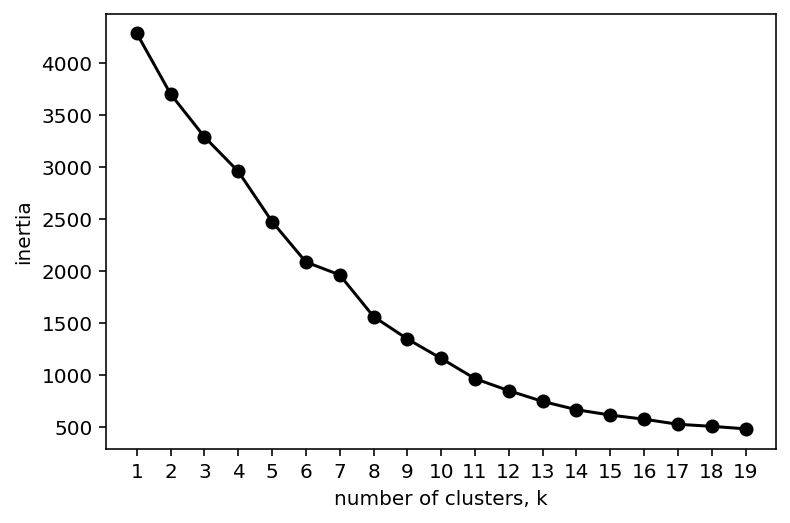

In [37]:
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:11])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#### We can see that after 6 clusters the inertia more or less drops off.

## 4. Cluster Neighborhoods

#### Run *k*-means to cluster the neighborhood into 6 clusters.

In [46]:
# set number of clusters
kclusters = 6

Toronto_merged_clustering = PCA_components.iloc[:,:11]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_merged_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 3, 1, 1, 1, 0, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 5 venues and top 5 ethnicities for each neighborhood.

In [47]:
# add clustering labels
Toronto_merged_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = DF_hoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(Toronto_merged_sorted.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common ethnicity,2nd Most Common ethnicity,3rd Most Common ethnicity,4th Most Common ethnicity,5th Most Common ethnicity
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1.0,Fast Food,Indian,Wings,Dim Sum,Diner,East Indian,Canadian,Sri Lankan,English,Filipino
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Pizza,Shawarma Place,Bakery,Restaurant,Mexican,East Indian,Canadian,English,Filipino,Sri Lankan
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Mexican,Indian,Korean,Wings,Diner,East Indian,Canadian,English,Filipino,Sri Lankan
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Hakka,Thai,Fried Chicken,Caribbean,Bakery,East Indian,Canadian,English,Filipino,Sri Lankan


#### The number of rows in our 'neighborhoods_venues_sorted' DataFrame is less than our original DataFrame. This will result in missing values(NaN). We remove these to create a new DataFrame

In [48]:
Toronto_merged_na = Toronto_merged.dropna()
Toronto_merged_na.head(25)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common ethnicity,2nd Most Common ethnicity,3rd Most Common ethnicity,4th Most Common ethnicity,5th Most Common ethnicity
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1.0,Fast Food,Indian,Wings,Dim Sum,Diner,East Indian,Canadian,Sri Lankan,English,Filipino
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Pizza,Shawarma Place,Bakery,Restaurant,Mexican,East Indian,Canadian,English,Filipino,Sri Lankan
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Mexican,Indian,Korean,Wings,Diner,East Indian,Canadian,English,Filipino,Sri Lankan
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Hakka,Thai,Fried Chicken,Caribbean,Bakery,East Indian,Canadian,English,Filipino,Sri Lankan
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1.0,Pizza,Falafel,Deli / Bodega,Dim Sum,Diner,Filipino,East Indian,Canadian,Chinese,English
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1.0,Comfort Food,Chinese,Restaurant,Wings,Deli / Bodega,Canadian,English,Irish,Scottish,Filipino
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1.0,Bakery,Indian,Chinese,Wings,Fast Food,Canadian,English,Irish,Scottish,Filipino
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1.0,American,Wings,Filipino,Diner,Doner,Canadian,English,Irish,Scottish,Filipino
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1.0,Japanese,Café,Pizza,Wings,Falafel,Canadian,English,Irish,Scottish,Filipino
10,M1P,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",43.757410,-79.273304,1.0,Indian,Vietnamese,Chinese,Fast Food,Diner,Filipino,East Indian,Canadian,Chinese,English


Finally, let's visualize the resulting clusters

In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged_na['Latitude'], Toronto_merged_na['Longitude'], Toronto_merged_na['Neighbourhood'], map(int, Toronto_merged_na['Cluster Labels'])):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [50]:
Toronto_merged_na.loc[Toronto_merged_na['Cluster Labels'] == 0, Toronto_merged_na.columns[[1] + list(range(5, Toronto_merged_na.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common ethnicity,2nd Most Common ethnicity,3rd Most Common ethnicity,4th Most Common ethnicity,5th Most Common ethnicity
55,Downtown Toronto,0.0,Restaurant,Italian,Café,Bakery,Sushi,English,Canadian,Irish,Scottish,Chinese
56,Downtown Toronto,0.0,Bakery,Italian,Sandwiches,Café,Steakhouse,English,Chinese,Irish,Canadian,Scottish
69,Downtown Toronto,0.0,Sandwiches,Italian,Café,Restaurant,Seafood,Canadian,Chinese,East Indian,English,Filipino


#### Cluster 2

In [51]:
Toronto_merged_na.loc[Toronto_merged_na['Cluster Labels'] == 1, Toronto_merged_na.columns[[1] + list(range(5, Toronto_merged_na.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common ethnicity,2nd Most Common ethnicity,3rd Most Common ethnicity,4th Most Common ethnicity,5th Most Common ethnicity
0,Scarborough,1.0,Fast Food,Indian,Wings,Dim Sum,Diner,East Indian,Canadian,Sri Lankan,English,Filipino
2,Scarborough,1.0,Pizza,Shawarma Place,Bakery,Restaurant,Mexican,East Indian,Canadian,English,Filipino,Sri Lankan
3,Scarborough,1.0,Mexican,Indian,Korean,Wings,Diner,East Indian,Canadian,English,Filipino,Sri Lankan
4,Scarborough,1.0,Hakka,Thai,Fried Chicken,Caribbean,Bakery,East Indian,Canadian,English,Filipino,Sri Lankan
5,Scarborough,1.0,Pizza,Falafel,Deli / Bodega,Dim Sum,Diner,Filipino,East Indian,Canadian,Chinese,English
6,Scarborough,1.0,Comfort Food,Chinese,Restaurant,Wings,Deli / Bodega,Canadian,English,Irish,Scottish,Filipino
7,Scarborough,1.0,Bakery,Indian,Chinese,Wings,Fast Food,Canadian,English,Irish,Scottish,Filipino
8,Scarborough,1.0,American,Wings,Filipino,Diner,Doner,Canadian,English,Irish,Scottish,Filipino
9,Scarborough,1.0,Japanese,Café,Pizza,Wings,Falafel,Canadian,English,Irish,Scottish,Filipino
10,Scarborough,1.0,Indian,Vietnamese,Chinese,Fast Food,Diner,Filipino,East Indian,Canadian,Chinese,English


#### Cluster 3

In [52]:
Toronto_merged_na.loc[Toronto_merged_na['Cluster Labels'] == 2, Toronto_merged_na.columns[[1] + list(range(5, Toronto_merged_na.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common ethnicity,2nd Most Common ethnicity,3rd Most Common ethnicity,4th Most Common ethnicity,5th Most Common ethnicity
58,Downtown Toronto,2.0,Café,Restaurant,Asian,Sandwiches,Thai,English,Chinese,Irish,Canadian,Scottish
60,Downtown Toronto,2.0,Café,Restaurant,Italian,Sandwiches,American,Canadian,Chinese,East Indian,English,Filipino
61,Downtown Toronto,2.0,Café,Restaurant,Italian,American,Seafood,Canadian,Chinese,East Indian,English,Filipino
70,Downtown Toronto,2.0,Café,Restaurant,American,Deli / Bodega,Italian,Canadian,Chinese,East Indian,English,Filipino


#### Cluster 4

In [53]:
Toronto_merged_na.loc[Toronto_merged_na['Cluster Labels'] == 3, Toronto_merged_na.columns[[1] + list(range(5, Toronto_merged_na.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common ethnicity,2nd Most Common ethnicity,3rd Most Common ethnicity,4th Most Common ethnicity,5th Most Common ethnicity
35,East York,3.0,Fast Food,Pizza,Breakfast,Gastropub,Café,English,Irish,Canadian,Scottish,French
36,East York,3.0,Snacks,Diner,Asian,Café,Wings,English,Irish,Canadian,Scottish,French
37,East Toronto,3.0,Burgers,Asian,Pizza,Wings,Dim Sum,English,Irish,Canadian,Scottish,French
38,East York,3.0,Sushi,Sandwiches,Pizza,Breakfast,Burgers,English,Canadian,Scottish,Irish,Chinese
40,East York,3.0,Bakery,Pizza,Wings,Falafel,Dim Sum,English,Irish,Scottish,Canadian,Chinese
41,East Toronto,3.0,Greek,Sushi,Italian,Restaurant,Pizza,English,Irish,Scottish,Canadian,Chinese
42,East Toronto,3.0,Pizza,Sandwiches,Italian,Sushi,Steakhouse,English,Irish,Canadian,Scottish,French
43,East Toronto,3.0,Café,Bakery,Gastropub,Italian,American,English,Irish,Scottish,Canadian,Chinese
47,Central Toronto,3.0,Pizza,Sandwiches,Café,American,Italian,English,Canadian,Irish,Scottish,Polish
48,Central Toronto,3.0,Hot Dogs,Restaurant,Wings,Falafel,Dim Sum,English,Irish,Scottish,Canadian,Chinese


#### Cluster 5

In [54]:
Toronto_merged_na.loc[Toronto_merged_na['Cluster Labels'] == 4, Toronto_merged_na.columns[[1] + list(range(5, Toronto_merged_na.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common ethnicity,2nd Most Common ethnicity,3rd Most Common ethnicity,4th Most Common ethnicity,5th Most Common ethnicity
77,West Toronto,4.0,Asian,Restaurant,Mexican,Café,Vegetarian / Vegan,English,Chinese,Irish,Canadian,Scottish


#### Cluster 6

In [55]:
Toronto_merged_na.loc[Toronto_merged_na['Cluster Labels'] == 5, Toronto_merged_na.columns[[1] + list(range(5, Toronto_merged_na.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common ethnicity,2nd Most Common ethnicity,3rd Most Common ethnicity,4th Most Common ethnicity,5th Most Common ethnicity
67,Downtown Toronto,5.0,Vietnamese,Café,Vegetarian / Vegan,Chinese,Dumplings,English,Irish,Scottish,Canadian,Chinese


<hr>
